see 
- https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/.
- https://arxiv.org/pdf/1606.05908.pdf
- https://arxiv.org/abs/1906.02691

reproduce:
- https://github.com/kumararduino/Variational-Auto-Encoder-VAE-

see the VAE code used in this notebook:
- <a href="mlutils/vae.py">vae.py</a>

We asume data $X$ can be reconstructed from a set of latent variables $z$ through a probabilistic generative model $P(X|z;\theta)$. This is, if given a specific value of $z$ and a set of fixed parameters $\theta$ (which are learnt from data) sampling from $P(X|z;\theta)$ will give us some $X$ usefully close enough to a desired one.

Our goal is to optimize likelihood

$$P(X) = \int P(X|z;\theta) P(z) dz = \mathbb{E}_{z\sim P(z)}P(X|z;\theta)$$

The integral can be seen as the expectation of $P(X|z;\theta)$ with respect to the distribution$P(z)$

**Problem 1**: The above expectation is hard because we do not know either of the distributions.

**VAE trick 1**: assume distributions are normal and then we use some function $f$ to transform them into their actual distributions. $f$ is the function to be learnt (for insance, a neural network) 

- $P(X|z;\theta) = \mathcal{N}(X|f(z;\theta), \sigma^2*I)$
- $P(z) = \mathcal{N}(0,I)$


**Problem 2**: The above expectation is difficult to compute by sampling from $P(z)$, because for most $z$, the probability $P(X|z)$ will be zero.

**VAE trick 2**: Build a distribution $Q(z|X)$ that gives us values of $z$ likely to have produced $X$. This way the **drive** what $z$'s are sampled with the help of $Q(z|X)$ in the expectation above. We now need to understand the relation between $P(X)$ and $\mathbb{E}_{z\sim Q(z|X)}P(X|z;\theta)$

This is the **key intuition** behind variational bayesian methods. If we try to make  $Q(z|X)$ as close as possible $P(z|X)$, we use [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) to measure its difference and minimize it.

$$D_{KL}[Q(z|X)||P(z|X)] = \int Q(z|X)\log \frac{Q(z|X)}{P(z|X)}=\mathbb{E}_{z \sim Q}[\log Q(z|X) -\log P(z|X)]$$

and applying Bayes theorem to $P(z|X)$

$$D_{KL}[Q(z|X)||P(z|X)] = \mathbb{E}_{z \sim Q}[\log Q(z|X) - \log P(X|z) - \log P(z) ] + \log P(x)$$


we can use the fact that:

 
$$D_{KL}[Q(z|X)||P(z)] = \mathbb{E}_{z \sim Q}[\log Q(z|X) - \log P(z) ]$$

and reorganize the expression above:

$$\log P(x) - D_{KL}[Q(z|X)||P(z|X)] = \mathbb{E}_{z \sim Q}[\log P(X|z) ] - D_{KL}[Q(z|X)||P(z)]$$


Note that $Q(z|X)$ can be seen as $Q$ encoding $X$ into $z$ and $P(X|z)$ can be seen as $P$ decoding $z$ into $X$.

Now, if we maximize the left hand side we  **BOTH** maximize $P(X)$ and minimize $D_{KL}[Q(z|X)||P(z|X)]$. 

**Problem 3**: The left hand side is intractable

**VAE Trick 3**: Maximize the right hand side.

**Problem 4**: We do not know what $Q(z|X)$ can be close enough to $P(z)$

**VAE Trick 4**: We do similarly to trick 1, assume normal distributions and learn functions to transform them to what we want:

$$Q(z|X) = \mathcal{N}(z|\mu (X;\vartheta), \Sigma (X;\vartheta))$$

where, like $f$, the functions $\mu$ and $\Sigma$ can be implemented and learnt as neural networks.

**Problem 5**: we need to compute $D_{KL}[Q(z|X)||P(z)]$

**VAE Trick 5**: since now of $Q(z|X)$ and $P(z)$ are normal the KL divergence has a closed form.

$$D_{KL}[Q(z|X)||P(z)] = \frac{1}{2}\Big(  \mathbf{tr}\Sigma(X) + \mu(X)\cdot\mu(X) -k - \text{det}\Sigma(X)\Big)$$

**Problem 6**: We need to compute $\mathbb{E}_{z \sim Q}[\log P(X|z) ]$ when doing gradient descent, but a MonteCarlo estimate is too expensive.

**VAE Trick 6**: Just take one sample $P(X|z)$ and compute the gradient with it. Anyhow we are doing stochastic gradient descent which is already sampling the data.

**Problem 7**: we can sample from $\mathbb{E}_{z \sim Q}[\log P(X|z) ]$ but we cannot backpropagate through it as sampling depends on the parameters or Q (which are $\mu$ and $\Sigma$) which are precisely the ones we are doing gradient descent upon.

**VAE Trick 7 (reparametrization trick)**: Sample $\epsilon \sim \mathcal{N}(0,I)$ and compute $z=\mu(X)+\Sigma^{1/2}(X)*\epsilon$




In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
print ("TF", tf.__version__, ":: TFP", tfp.__version__)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

TF 1.13.1 :: TFP 0.6.0


In [3]:
from mlutils import vae
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

### download data

In [4]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size ** 2]).astype('float32') / 255
x_test = np.reshape(x_test, [-1, image_size ** 2]).astype('float32') / 255


11493376/11490434 [==============================] - 47s 4us/step


### build autoencoder (see `vae.py`)

In [5]:
mvae = vae.VAE(original_dim=image_size ** 2,
                    intermediate_dim = 512,
                    latent_dim = 2)
mvae.build()

Instructions for updating:
Colocations handled automatically by placer.


### train network

In [6]:
mvae.fit(x_train, x_test, batch_size=128, epochs=50)

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
60000/60000 [==============================] - 16s 271us/sample - loss: 196.0487 - val_loss: 171.5970
Epoch 2/50
60000/60000 [==============================] - 25s 412us/sample - loss: 168.6155 - val_loss: 166.4100
Epoch 3/50
60000/60000 [==============================] - 21s 345us/sample - loss: 164.9887 - val_loss: 164.1879
Epoch 4/50
60000/60000 [==============================] - 22s 373us/sample - loss: 162.8063 - val_loss: 162.0662
Epoch 5/50
60000/60000 [==============================] - 25s 415us/sample - loss: 161.0728 - val_loss: 160.5733
Epoch 6/50
60000/60000 [==============================] - 18s 307us/sample - loss: 159.6099 - val_loss: 159.4538
Epoch 7/50
60000/60000 [==============================] - 21s 353us/sample - loss: 158.3455 - val_loss: 158.2388
Epoch 8/50
60000/60000 [==============================] - 20s 333us/sample - loss: 157.1430 - val_loss: 157.207

In [27]:
mvae.save_weights("mvae_weights/w")


Consider using a TensorFlow optimizer from `tf.train`.


In [28]:
mvae.load_weights("mvae_weights/w")

### represent test data in latent space

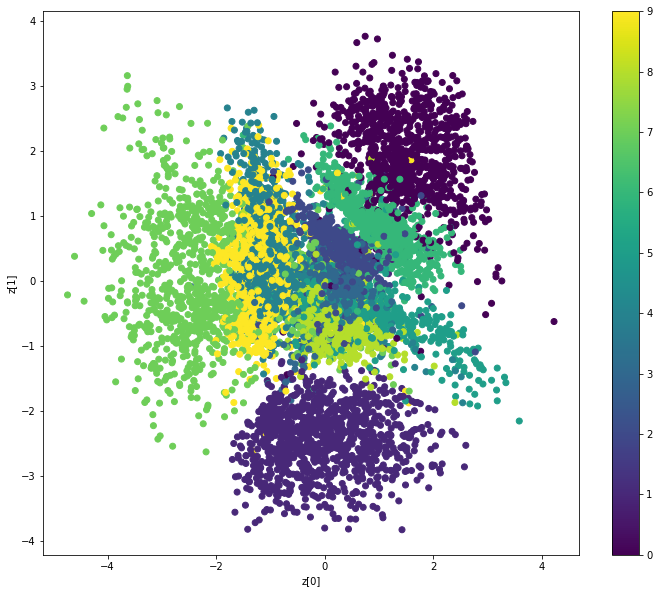

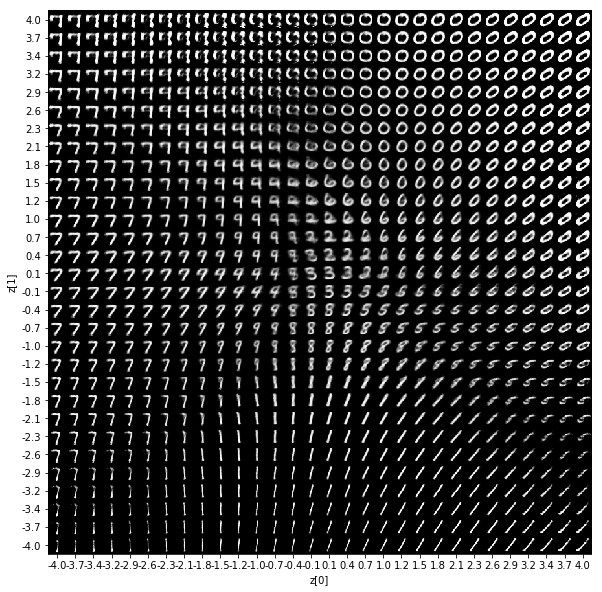

In [29]:
mvae.plot_results(x_test, y_test)

### sample the latent space

obtain evaluable functions from keras

In [9]:
from tensorflow.keras import backend as K
fz       = K.function(inputs=[mvae.inputs, K.learning_phase()], outputs=[mvae.z])
fzmean   = K.function(inputs=[mvae.inputs, K.learning_phase()], outputs=[mvae.z_mean])
fzlogvar = K.function(inputs=[mvae.inputs, K.learning_phase()], outputs=[mvae.z_log_var])

choose a random $x_i$

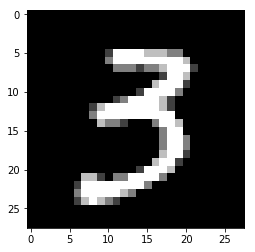

In [10]:
xi = x_test[[np.random.randint(len(x_test))]]
plt.imshow(xi[0].reshape(28,28), cmap=plt.cm.gray)

The distribution of the latent variables is:

$$z_i \sim \mathcal{N}(\mu_{x_i}, \sigma_{x_i})$$

In [11]:
mu_zi = fzmean(xi)
sigma_zi = fzlogvar(xi)
mu_zi, sigma_zi

([array([[ 0.3342958 , -0.20109978]], dtype=float32)],
 [array([[-7.3831005, -7.5661983]], dtype=float32)])

Two samples of the latent variables $z_i$

In [12]:
fz(xi)

[array([[ 0.3489899, -0.2128311]], dtype=float32)]

In [13]:
fz(xi)

[array([[ 0.32161176, -0.16914964]], dtype=float32)]

A histogram of samples of the latent variables for this input

In [14]:
dxt = np.r_[[fz(xi)[0][0] for i in range(1000)]]
print (dxt.shape)
print ("from sample  mu/sigm", np.mean(dxt, axis=0), np.std(dxt, axis=0))
print ("distribution mu/sigm", mu_zi[0][0], np.exp(.5*sigma_zi[0][0]))

(1000, 2)
from sample  mu/sigm [ 0.3339489  -0.20138557] [0.02505719 0.02315003]
distribution mu/sigm [ 0.3342958  -0.20109978] [0.02493332 0.02275207]


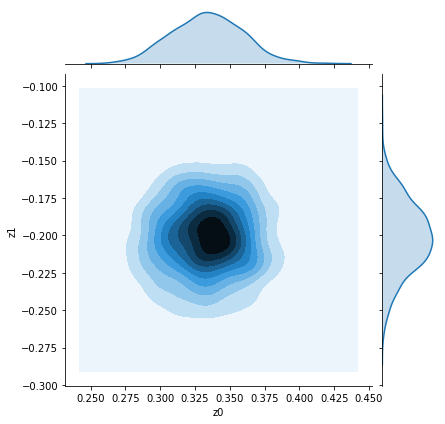

In [15]:
sns.jointplot(x="z0", y="z1", data=pd.DataFrame(dxt, columns=["z0", "z1"]), kind="kde");

### sample output distributions

In [16]:
fout_from_input = K.function(inputs=[mvae.inputs, K.learning_phase()], outputs=[mvae.outputs])
fout_from_latent = K.function(inputs=[[mvae.latent_inputs], K.learning_phase()], 
                              outputs=[mvae.doutputs])

end to end

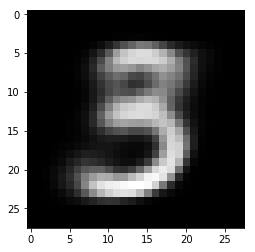

In [17]:
oxi = fout_from_input(xi)[0][0]
plt.imshow(oxi.reshape(28,28), cmap=plt.cm.gray)

by first sampling the latent variables

latent [ 0.3201126  -0.21280493]


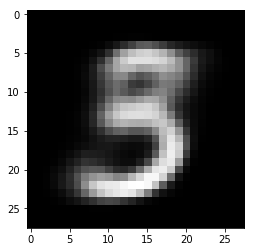

In [18]:
zi = fz(xi)
print ("latent", zi[0][0])
ozi = fout_from_latent(zi)[0][0]
plt.imshow(ozi.reshape(28,28), cmap=plt.cm.gray)

obtain all values of $z_{mean}$ for every input image and average them. Should be close to zero as $z \sim \mathcal{N}(0,I)$


In [19]:
zs = np.r_[[fz(i.reshape(1,-1))[0][0] for i in x_train]]
zs.shape, np.mean(zs,axis=0),  np.std(zs,axis=0)

((60000, 2),
 array([-0.05516221, -0.02431376], dtype=float32),
 array([1.2315979, 1.2451104], dtype=float32))

In [20]:
zs = np.r_[[fz(i.reshape(1,-1))[0][0] for i in x_test]]
zs.shape, np.mean(zs,axis=0),  np.std(zs,axis=0)

((10000, 2),
 array([-0.08755009, -0.00795521], dtype=float32),
 array([1.1921984, 1.2266319], dtype=float32))

In [21]:
xi.shape

(1, 784)

In [22]:
for i in x_test:
    print (i.shape, fz(i.reshape(1,-1))[0][0])
    break

(784,) [-3.431114   -0.35673934]


In [23]:
xi.shape, i.shape

((1, 784), (784,))